In [1]:
import os
import sys
sys.path.append('/home/danylokolinko/hpa')
import copy
import argparse
import numpy as np
import yaml
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd
import os
import imageio
from tqdm.notebook import tqdm

from hpa_competition.model_training.common.augmentations import get_transforms

from hpa_competition.PuzzleCAM.core.networks import *
from hpa_competition.PuzzleCAM.core.datasets import *

from hpa_competition.PuzzleCAM.tools.general.io_utils import *
from hpa_competition.PuzzleCAM.tools.general.time_utils import *
from hpa_competition.PuzzleCAM.tools.general.json_utils import *

from hpa_competition.PuzzleCAM.tools.ai.log_utils import *
from hpa_competition.PuzzleCAM.tools.ai.demo_utils import *
from hpa_competition.PuzzleCAM.tools.ai.optim_utils import *
from hpa_competition.PuzzleCAM.tools.ai.torch_utils import *
from hpa_competition.PuzzleCAM.tools.ai.evaluate_utils import *

from hpa_competition.PuzzleCAM.tools.ai.augment_utils import *
from hpa_competition.PuzzleCAM.tools.ai.randaugment import *
from hpa_competition.model_training.common.datasets import HPADatasetCAMTest, HPADatasetCAM

from hpa_competition.model_training.classification.utils import  get_df_cam, build_image_names, read_img, get_cam, load_RGBY_image, print_masked_img
import torch

import os
import pandas as pd
import numpy as np
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import cv2
from multiprocessing import Pool


import hpacellseg.cellsegmentator as cellsegmentator
from hpacellseg.utils import label_cell, label_nuclei
from concurrent.futures import ThreadPoolExecutor

from hpa_competition.model_training.classification.utils import load_RGBY_image
from hpa_competition.PuzzleCAM.tools.ai.torch_utils import one_hot_embedding

In [2]:
import base64
import numpy as np
from pycocotools import _mask as coco_mask
import typing as t
import zlib


def encode_binary_mask(mask: np.ndarray) -> t.Text:
      """Converts a binary mask into OID challenge encoding ascii text."""

      # check input mask --
      if mask.dtype != np.bool:
        raise ValueError(
            "encode_binary_mask expects a binary mask, received dtype == %s" %
            mask.dtype)

      mask = np.squeeze(mask)
      if len(mask.shape) != 2:
        raise ValueError(
            "encode_binary_mask expects a 2d mask, received shape == %s" %
            mask.shape)

      # convert input mask to expected COCO API input --
      mask_to_encode = mask.reshape(mask.shape[0], mask.shape[1], 1)
      mask_to_encode = mask_to_encode.astype(np.uint8)
      mask_to_encode = np.asfortranarray(mask_to_encode)

      # RLE encode mask --
      encoded_mask = coco_mask.encode(mask_to_encode)[0]["counts"]

      # compress and base64 encoding --
      binary_str = zlib.compress(encoded_mask, zlib.Z_BEST_COMPRESSION)
      base64_str = base64.b64encode(binary_str)
      return base64_str

In [3]:
with open(os.path.join('config', 'cam_avenga.yaml')) as config_file:
    config = yaml.full_load(config_file)

print(config['model']['model_path'])

log_func = lambda string='': print(string)

model = Classifier(config['model']['arch'], False, config['model']['classes'], mode='normal')

model.cuda()
model.eval()

use_gpu = '0'

the_number_of_gpu = len(use_gpu.split(','))
if the_number_of_gpu > 1:
    log_func('[i] the number of gpu : {}'.format(the_number_of_gpu))
    model = nn.DataParallel(model)

load_model(model, config['model']['model_path'], parallel=the_number_of_gpu > 1)

eval_timer = Timer()
scales = [float(scale) for scale in [0.5, 1, 1.5, 2]]

eval_timer.tik()

testdf = pd.read_csv(os.path.join(config['test']['path'], 'sample_submission.csv' ))
test_transform = get_transforms(config['test']['transform'])
train_transform = get_transforms(config['train']['transform'])


test_dataset = HPADatasetCAMTest(config['test']['path'], testdf, transform=test_transform, img_size=None, yellow=True, segm_models=config['segm_model'])

train_df = get_df_cam(path=config['train']['path'])
# train_df = df.loc[~df.is_valid].reset_index(drop=True)
# val_df = df.loc[df.is_valid].reset_index(drop=True)
# path = config['train']['path']

train_dataset = HPADatasetCAM(config['train']['path'], train_df, transform=test_transform, yellow=True)

train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], num_workers=config['args']['num_workers'], shuffle=True,
                              drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=config['batch_size'], num_workers=config['args']['num_workers'], shuffle=False,
                              drop_last=False)
# test_loader = DataLoader(test_dataset, batch_size=2, num_workers=config['args']['num_workers'], shuffle=False,
#                               drop_last=False)

segmentator = cellsegmentator.CellSegmentator(
    config['segm_model']['nuclei_path'],
    config['segm_model']['cell_path'],
    scale_factor=0.25,
    device='cuda',
    padding=True,
    multi_channel_model=True
)

/home/danylokolinko/logs/cam/models/efficientnet-b0-2021-04-12-22-05-41.pth


/home/danylokolinko/venv_hpa/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass shuffle=False, random_state=None as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


please compile abn


/home/danylokolinko/venv_hpa/lib/python3.8/site-packages/torch/serialization.py:656: SourceChangeWarning: source code of class 'pytorch_zoo.unet.DPNUnet' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/danylokolinko/venv_hpa/lib/python3.8/site-packages/torch/serialization.py:656: SourceChangeWarning: source code of class 'torch.nn.modules.container.ModuleList' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/danylokolinko/venv_hpa/lib/python3.8/site-packages/torch/serialization.py:656: SourceChangeWarning: source code of class 'torch.nn.modules.container.Sequential' has changed. you can retrieve the original source 

In [4]:
#TODO: clean up
def cust(tupp):
    nuc_segmentations, cell_segmentations, CAMs = tupp
    cur_nuclei_mask, cur_cell_mask = label_cell(nuc_segmentations, cell_segmentations)
    cur_cams = resize_for_tensors(CAMs.unsqueeze(0), cur_nuclei_mask.shape)[0]
    image_preds = []
    image_rles = []
    
    for cell_idx in range(1, cur_cell_mask.max()+1):
        image_rles.append(encode_binary_mask(cur_cell_mask == cell_idx))
        current_cell_lst = []
        for class_id in range(19):
            result = cur_cams[class_id-1]*(cur_nuclei_mask==cell_idx)
            num_pixels = np.count_nonzero(result)
            logits = result.sum().item()/num_pixels if num_pixels else 0
#                 prob = logits/thresh
            max_logits[class_id] = max(logits, max_logits[class_id])
            current_cell_lst.append(logits)
        image_preds.append(copy.deepcopy(current_cell_lst))
    return [copy.deepcopy(image_preds), copy.deepcopy(image_rles)]



In [13]:
max_logits = [0 for i in range(19)]

from concurrent.futures import ThreadPoolExecutor
dir_path = '/common/danylokolinko/hpa'
train = False
img_dir = os.path.join(dir_path, ('train' if train else 'test'))

glob_preds = []
with torch.no_grad():
    for step, (ori_image, image_id) in (enumerate(tqdm(test_loader))):
#         segm_X = ori_image[:, [0, 1, 3]].numpy().transpose([0, 2, 3, 1])
        ori_image = ori_image.cuda()
        X = ori_image[:, [0, 2, 3]]
        CAMs= get_cam(model, X, 1).cpu()
        images = build_image_names(image_id, img_dir)[-1]
        nuc_segmentations = segmentator.pred_nuclei(images[2])

        cell_segmentations = segmentator.pred_cells(images)
#         for i in range(len(nuc_segmentations)):
#             cur_nuclei_mask, cur_cell_mask = label_cell(nuc_segmentations9[i], cell_segmentations[i])
            
        
#         CAMs = resize_for_tensors(CAMs, cell_segmentations[idx].shape[:-1])[idx]

    
        params_lst = [(nuc_segmentations[i], cell_segmentations[i], CAMs[i]) for i in range(len(cell_segmentations))]
        with Pool(16) as executor:
            results = executor.map(cust, params_lst)    
                
        glob_preds += list(results)
        

  0%|          | 0/28 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [21]:
dir_path = '/common/danylokolinko/hpa'
class Inferer:
    def __init__(dir_path, train = False)
        self.dir_path = dir_path
        img_dir = os.path.join(dir_path, ('train' if train else 'test'))
    def infer():
        pass

tensor(0.0912)

In [23]:
max_logits = list(map(lambda x: x if x!=0 else 1, max_logits))
def from_preds2string(preds):
    image_preds = preds[0]
    image_rles = preds[1]
    strt = " ".join([f'{class_idx} {logit/max_logits[class_idx]} {rle}'  for pred, rle in zip(image_preds, image_rles) for class_idx, logit  in enumerate(pred)])
    return strt

from_preds2stringpred = list(map(from_preds2string, glob_preds))

In [37]:
ss_df.to_csv("/kaggle/working/submission.csv", index=False)

,ID,ImageWidth,ImageHeight,PredictionString,pred_str
0,0040581b-f1f2-4fbe-b043-b6bfea5404bb,2048,2048,0 1 eNoLCAgIMAEABJkBdQ==,0 0.0 b'eNqtVm2PojAQ/ksMZe+Sy21yubtc4gKDIkpBUJ...
1,004a270d-34a2-4d60-bbe4-365fca868193,2048,2048,0 1 eNoLCAgIMAEABJkBdQ==,0 0.0 b'eNoLCEhJMAgwDMg3NPQ39Df2tXaF0PaOENrYF0...
2,00537262-883c-4b37-a3a1-a4931b6faea5,2048,2048,0 1 eNoLCAgIMAEABJkBdQ==,0 0.0 b'eNqFUE0LwjAM/UtJuqlM8AsUN9fWgzcVlDEPMv...
3,00c9a1c9-2f06-476f-8b0d-6d01032874a2,2048,2048,0 1 eNoLCAgIMAEABJkBdQ==,0 0.0 b'eNrtVUtvwjAM/ktxAutp2mGXDhpHGpDCxvuZQt...
4,0173029a-161d-40ef-af28-2342915b22fb,3072,3072,0 1 eNoLCAgIsAQABJ4Beg==,0 0.0 b'eNqtlFuXmjAQgP8SDOgB2peeLsueXccgbgWRiw...
...,...,...,...,...,...
554,fea47298-266a-4cf4-93bd-55d1bcc2fc7d,1728,1728,0 1 eNoLCAjJNgIABNkBkg==,0 0.0 b'eNqFUNsOgjAM/aV1XMQ/gOHa4P1BECTGS4L+/5...
555,feb955db-6c07-4717-a98b-92236c8e01d8,2048,2048,0 1 eNoLCAgIMAEABJkBdQ==,0 0.0 b'eNqVld3O4jYQhm8p43RpqLqV2gpQ98OTHydxnB...
556,fefb9bb7-934a-40d1-8d2f-210265857388,2048,2048,0 1 eNoLCAgIMAEABJkBdQ==,0 0.0 b'eNqtUrsOwjAM/CU7aXmIGaE+kiAVCbrBUhBL/3...
557,ff069fa2-d948-408e-91b3-034cfea428d1,3072,3072,0 1 eNoLCAgIsAQABJ4Beg==,0 0.0 b'eNq1FV1vgjDwL5WjsCWLT9sysVyJnQjqnDpxrQ...


In [36]:
len(glob_preds[0][0])

15

In [28]:
testdf["pred_str"] = np.array(from_preds2stringpred)

  0%|          | 0/1090 [00:00<?, ?it/s]

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.])


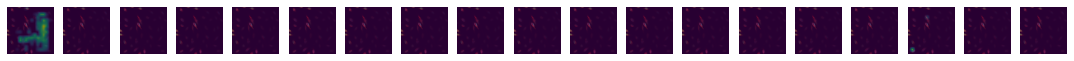

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0.])


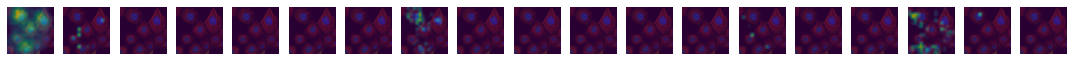

tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.])


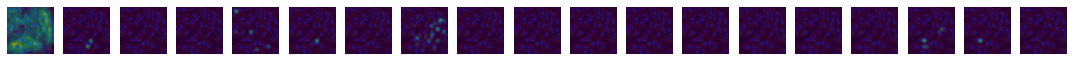

tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.])


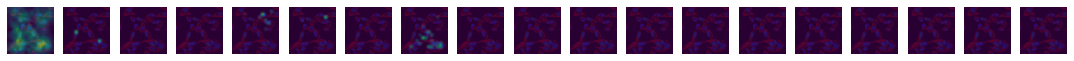

tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.])


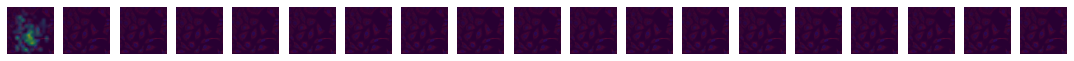

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.])


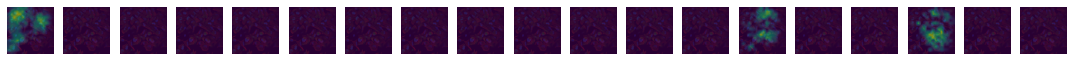

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0.,
        0.])


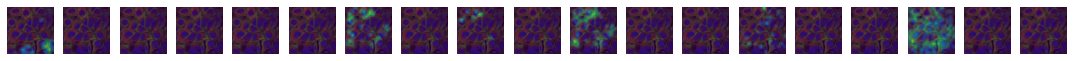

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.])


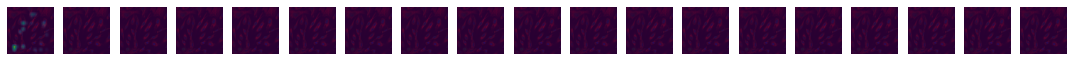

tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.])


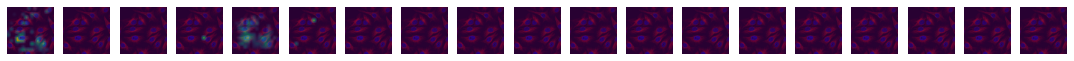

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0.])


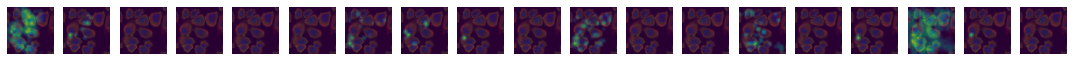

tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.])


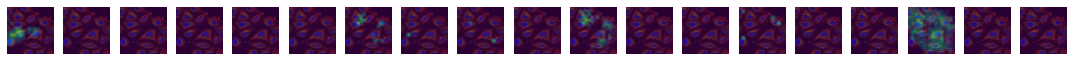

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.])


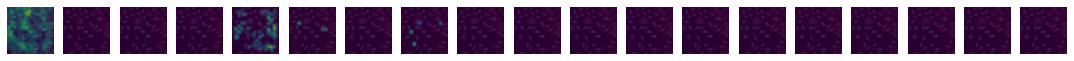

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0.])


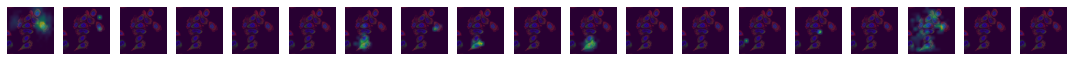

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.])


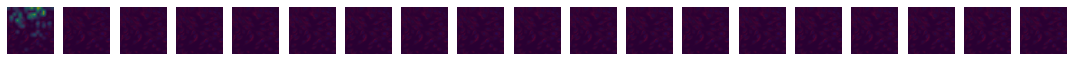

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.])


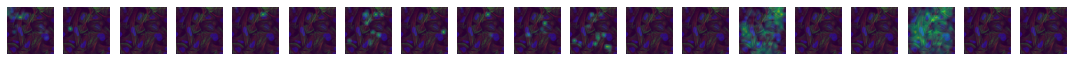

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
        0.])


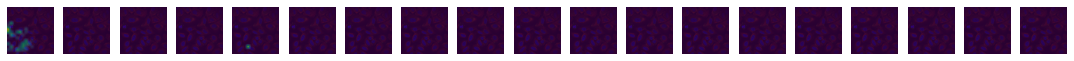

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0.])


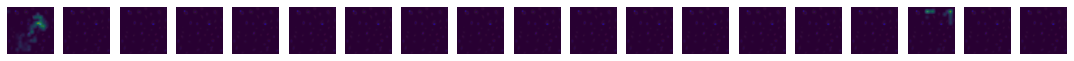

tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.])


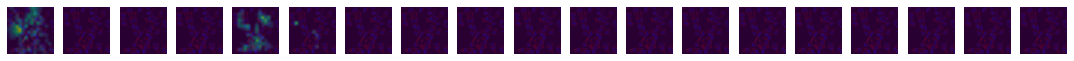

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0.])


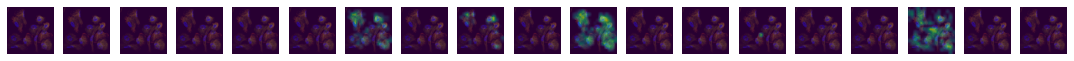

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0.])


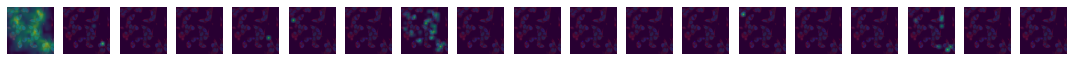

tensor([1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0.])


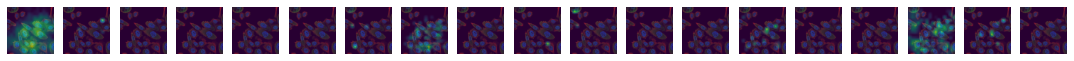

tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.])


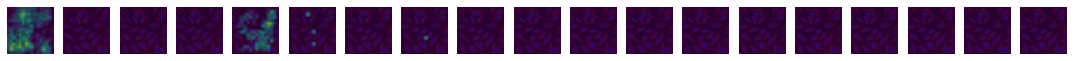

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0.])


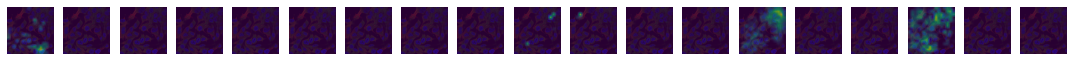

tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.])


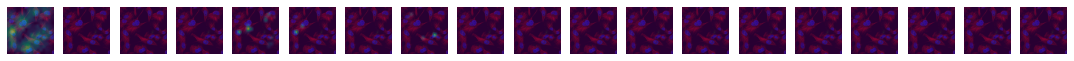

tensor([1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.])


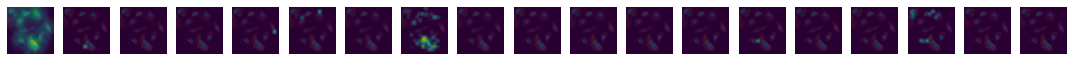

tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.])


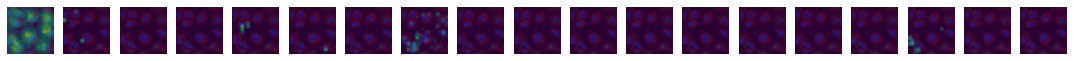

tensor([1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0.])


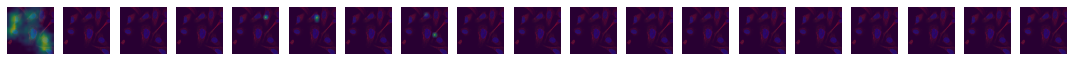

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.])


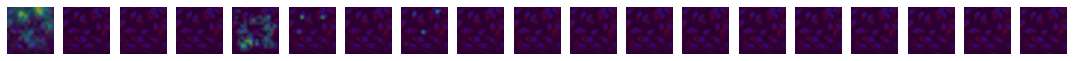

tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.])


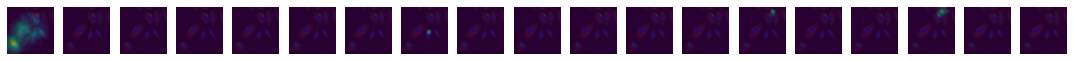

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0.])


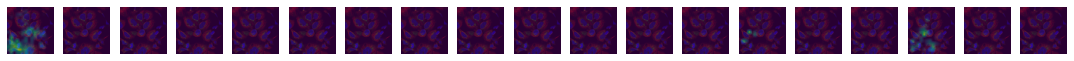

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0.])


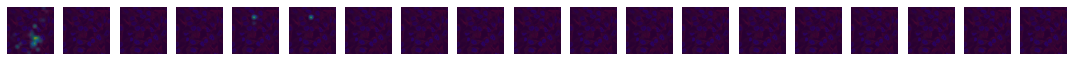

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0.])


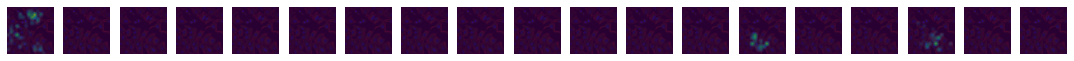

tensor([0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.])


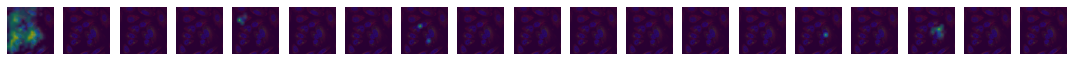

tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0.])


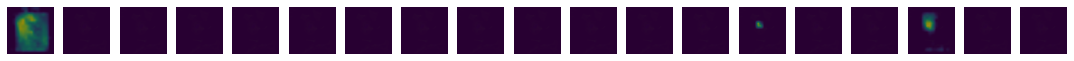

tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.])


KeyboardInterrupt: 

In [43]:
max_logits = [0 for i in range(19)]

from concurrent.futures import ThreadPoolExecutor
dir_path = '/common/danylokolinko/hpa'
train = True
img_dir = os.path.join(dir_path, ('train' if train else 'test'))

glob_preds = []
with torch.no_grad():
    for step, (ori_image, labels, image_id) in (enumerate(tqdm(train_loader))):
        segm_X = ori_image[:, [0, 1, 3]].numpy().transpose([0, 2, 3, 1])
        ori_image = ori_image.cuda()
        X = ori_image[:, [0, 2, 3]]
        CAMs= get_cam(model, X, 1).cpu()
        images = build_image_names(image_id, img_dir)[-1]
        nuc_segmentations = segmentator.pred_nuclei(images[2])
    
        cell_segmentations = segmentator.pred_cells(images)
#         plt.imshow(cell_segmentations[idx])
#         print(cell_segmentations[0].shape)
        
        HR_CAMs = resize_for_tensors(CAMs, (512, 512))
#         print()
#         plt.imshow(CAMs[0], alpha=0.6)
        for i in range(len(image_id)):
            print(labels[i])
#             curcam = resize_for_tensors(CAMs[i], cell_segmentations[idx].shape[:-1])[idx]
            print_masked_img(dir_path, image_id[i], HR_CAMs[i], 'train')

    
#         params_lst = [(nuc_segmentations[i], cell_segmentations[i], CAMs[i]) for i in range(test_loader.batch_size)]
#         with ThreadPoolExecutor(16) as executor:
#             results = executor.map(cust, params_lst)    
                
#         glob_preds += list(results)